# Process optimization by genetic algorithm

10 same items scheduling

In [304]:
include("../../src/ProcGA.jl")

Main.ProcGA

In [144]:
using CSV
using DelimitedFiles
using DataFrames
using Missings
using Statistics

In [14]:
using Plots, Plotly

┌ Info: Precompiling Plotly [58dd65bb-95f3-509e-9936-c39a10fdeae7]
└ @ Base loading.jl:1192


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ca093309b313bb1b910f847fbc5df50a50de9ece-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ca093309b313bb1b910f847fbc5df50a50de9ece-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [164]:
gr()

Plots.GRBackend()

## reading data

In [16]:
ptbl = CSV.read("proctable.csv",header = 1);

In [17]:
# take smaller size 
ptbl = ptbl[1:10,:];

In [18]:
mtbl = convert(Array, ptbl[1:2])

10×2 Array{Any,2}:
 "BB105 間管"       50
 "BB201-3 3補助管2"  50
 "BH301M 間管"      50
 "BH301M 枝管1"     50
 "BH301M 枝管2"     50
 "EP201 間管"       50
 "EP201-2 2補助管"   50
 "EP201-2 枝管1"    50
 "HR567 枝管4"      50
 "HR567 枝管4C"     50

In [19]:
ptbl2 = [coalesce.(x,0) for x in convert(Array, ptbl[3:end])]

10×14 Array{Int64,2}:
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2

In [20]:
s = string.(names(ptbl)[3:end])

14-element Array{String,1}:
 "pipecut"           
 "anneal_bs_prebend" 
 "anneal_ns_prebend" 
 "icing"             
 "rotbend"           
 "pressbend"         
 "anneal_bs_precalib"
 "anneal_ns_precalib"
 "vcalib"            
 "hcalib"            
 "buff_precut"       
 "mc_cut"            
 "buff_postcut"      
 "qc_check"          

In [21]:
nametable = DataFrame(id = 1:length(s), nm = s)

,id,nm
1,1,pipecut
2,2,anneal_bs_prebend
3,3,anneal_ns_prebend
4,4,icing
5,5,rotbend
6,6,pressbend
7,7,anneal_bs_precalib
8,8,anneal_ns_precalib
9,9,vcalib
10,10,hcalib


Read grouping info.

In [68]:
gtbl = readdlm("grouping.csv",',', skipstart = 1)

2×5 Array{Any,2}:
 "anneal_bs"  "[2;7]"  300  3  1
 "anneal_ns"  "[3;8]"  300  3  1

In [69]:
gtbl2=[]
for k in 1:size(gtbl)[1]
    x = gtbl[k, 2:end]
    push!(gtbl2,Dict(:id=>eval(Meta.parse(x[1])),:cnt=>x[2],:timespan=>x[3],:grp=>x[4]))
end

In [70]:
gtbl2

2-element Array{Any,1}:
 Dict{Symbol,Any}(:timespan=>3,:id=>[2, 7],:cnt=>300,:grp=>1)
 Dict{Symbol,Any}(:timespan=>3,:id=>[3, 8],:cnt=>300,:grp=>1)

## Initialize ProcGA tables.

In [305]:
ProcGA.settable(ptbl2, gtbl2, mtbl)

()

## Initialize population

In [325]:
savedfile = "bestprc_heuristics.csv"

"bestprc_heuristics.csv"

In [326]:
# create population from savedfile or make new
if isfile(savedfile)
    println("read from $savedfile")
    gbs = readdlm(savedfile, ',', Int)
else
    println("Read base data manually created from 6-same best practice.")
    g1 = ProcGA.jobtablebase()
    bs = readdlm("10same.csv",',',Int)
    ca = size(g1)[2]-size(bs)[2]
    gbs = hcat(bs,zeros(Int,(10,ca)))
end
gbs

read from bestprc_heuristics.csv


10×120 Array{Int64,2}:
 1  0  7  7  7  9  9  12  12  13  13  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  7  7  7  0  0   9   9  12  12     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  7   7   7   9   9     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  7   7   7   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  7   7   7   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0   0   0   7   7  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1   0   0   7   7     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0   1   0   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0   0   1   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0   0   0   1   0     0  0  0  0  0  0  0  0  0  0  0  0

In [327]:
ProcGA.penalty(gbs)

31

In [328]:
ProcGA.dupenalty(gbs)

0

Make population.
Half of it is from best data and latter half is randomly made.

In [329]:
ppl = ProcGA.initpopulationfrom(gbs,100);
ppl = vcat(ppl, ProcGA.initpopulation(100));

## Defining penalty functions

You can give your own penalty function when needed.

In [330]:
# ProcGA.penalty(jtbl) = mypenalty(jtbl)

In [331]:
# ProcGA.penalty(jtbl) = ProcGA.orgpenalty(jtbl)

In [332]:
function mypenalty(jtbl)
    p = ProcGA.validlength(jtbl)
    p += ProcGA.serpenalty(jtbl)
    p += ProcGA.grpenalty(jtbl)
    p += ProcGA.grdupenalty(jtbl)
    p += 2*ProcGA.dupenalty(jtbl) # weight
    p
end

# ProcGA.penalty(jtbl) = mypenalty(jtbl)

mypenalty (generic function with 1 method)

## Evolution!

In [333]:
# first sort ppl by their penalties
ProcGA.sortpopulation!(ppl);

In [334]:
v = ProcGA.penalty.(ppl)

200-element Array{Int64,1}:
  31
  31
  31
  31
  31
  31
  31
  31
  31
  32
  33
  34
  35
   ⋮
 785
 794
 795
 799
 803
 805
 806
 807
 814
 836
 884
 897

In [335]:
vlst = [(minimum(v), median(v), maximum(v))]

1-element Array{Tuple{Int64,Float64,Int64},1}:
 (31, 444.5, 897)

In [336]:
# Proceed generation
vl = ProcGA.evolution!(ppl, 500, 10);
vlst = vcat(vlst,vl);

i:10 => (31, 31.0, 59)
i:20 => (31, 31.0, 45)
i:30 => (31, 31.0, 40)
i:40 => (31, 31.0, 66)
i:50 => (31, 31.0, 56)
i:60 => (31, 31.0, 54)
i:70 => (31, 31.0, 90)
i:80 => (31, 31.0, 60)
i:90 => (31, 31.0, 62)
i:100 => (31, 31.0, 48)
i:110 => (31, 31.0, 57)
i:120 => (31, 31.0, 49)
i:130 => (31, 31.0, 58)
i:140 => (31, 31.0, 66)
i:150 => (31, 31.0, 66)
i:160 => (31, 31.0, 56)
i:170 => (31, 31.0, 59)
i:180 => (31, 31.0, 50)
i:190 => (31, 31.0, 50)
i:200 => (31, 31.0, 66)
i:210 => (31, 31.0, 65)
i:220 => (31, 31.0, 53)
i:230 => (31, 31.0, 58)
i:240 => (31, 31.0, 50)
i:250 => (31, 31.0, 31)
i:260 => (31, 31.0, 65)
i:270 => (31, 31.0, 59)
i:280 => (31, 31.0, 59)
i:290 => (31, 31.0, 46)
i:300 => (31, 31.0, 58)
i:310 => (31, 31.0, 65)
i:320 => (31, 31.0, 55)
i:330 => (31, 31.0, 63)
i:340 => (31, 31.0, 45)
i:350 => (31, 31.0, 70)
i:360 => (31, 31.0, 65)
i:370 => (31, 31.0, 66)
i:380 => (31, 31.0, 71)
i:390 => (31, 31.0, 63)
i:400 => (31, 31.0, 50)
i:410 => (31, 31.0, 60)
i:420 => (31, 31.0, 62)
i

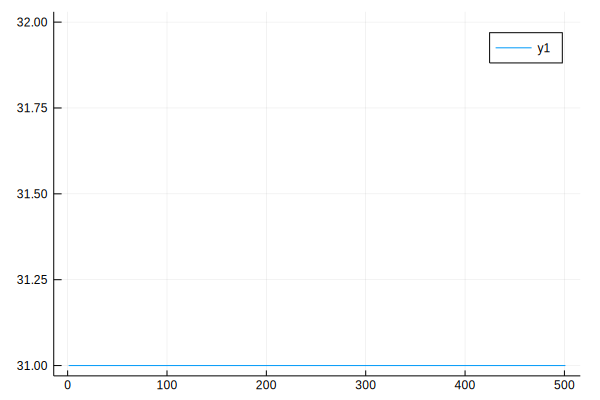

In [337]:
y = (x->x[1]).(vlst);
x = 1:length(y);

plot(x,y)

Pick up the best data.

In [338]:
v = ProcGA.penalty.(ppl)
idm = findmin(v)[2]
bestgen = ppl[idm]

10×120 Array{Int64,2}:
 1  0  7  7  7  9  9  12  12  13  13  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  7  7  7  0  0   9   9  12  12     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  7   7   7   9   9     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  7   7   7   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  7   7   7   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0   0   0   7   7  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1   0   0   7   7     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0   1   0   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0   0   1   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0   0   0   1   0     0  0  0  0  0  0  0  0  0  0  0  0

In [339]:
ProcGA.penalty(bestgen)

31

In [340]:
ProcGA.dupenalty(bestgen)

0

In [341]:
ProcGA.validlength(bestgen)

31

In [342]:
ProcGA.clipjob(bestgen)

10×31 Array{Int64,2}:
 1  0  7  7  7  9  9  12  12  13  13  …   0   0   0   0   0   0   0   0   0
 0  1  7  7  7  0  0   9   9  12  12      0   0   0   0   0   0   0   0   0
 0  0  1  0  0  0  7   7   7   9   9      0   0   0   0   0   0   0   0   0
 0  0  0  1  0  0  7   7   7   0   0      0   0   0   0   0   0   0   0   0
 0  0  0  0  1  0  7   7   7   0   0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  1  0   0   0   7   7  …  14   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  1   0   0   7   7     13  14  14   0   0   0   0   0   0
 0  0  0  0  0  0  0   1   0   0   0     12  13  13  14  14   0   0   0   0
 0  0  0  0  0  0  0   0   1   0   0      9  12  12  13  13  14  14   0   0
 0  0  0  0  0  0  0   0   0   1   0      0   9   9  12  12  13  13  14  14

Sort it by first appearance of process.

In [343]:
idx = zeros(Int,10)
for i in 1:10
    idx[i] = findfirst(x->(x>0),bestgen[i,:])
end

In [344]:
id2 = sort(collect(1:10), by = x->idx[x])

10-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [345]:
bestgensort = similar(bestgen)
for i in 1:size(bestgen)[1]
    bestgensort[i,:] = bestgen[id2[i],:]
end
bestgensort

10×120 Array{Int64,2}:
 1  0  7  7  7  9  9  12  12  13  13  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  7  7  7  0  0   9   9  12  12     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  7   7   7   9   9     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  7   7   7   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  7   7   7   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0   0   0   7   7  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1   0   0   7   7     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0   1   0   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0   0   1   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0   0   0   1   0     0  0  0  0  0  0  0  0  0  0  0  0

In [347]:
# save best process table to file.
# do not clip it so that it can be used again
writedlm("bestprc.csv",bestgensort, ',')

## Conclusion

For given 10 same data with proctalbe below, the best combination is "bestgen" here.

Its length is 33.
Taking time unit as 1 hour and assuming job time as 7 hours/day, it needs almost 5 days to finish these materials.

In [140]:
transpose(ProcGA.proctable[1,:])

1×14 LinearAlgebra.Transpose{Int64,Array{Int64,1}}:
 1  0  0  0  0  0  3  0  2  0  0  2  2  2

In [141]:
ProcGA.clipjob(bestgen)

10×33 Array{Int64,2}:
 1  7  7  7  0  0  0  0  0   9   9   0  …   0   0   0   0   0   0   0   0   0
 0  1  0  0  7  7  7  0  0   0   0   0      0   0   0  14  14   0   0   0   0
 0  0  1  0  7  7  7  9  9  12  12  13      0   0   0   0   0   0   0   0   0
 0  0  0  1  0  0  0  7  7   7   0   9     14   0   0   0   0   0   0   0   0
 0  0  0  0  1  0  0  0  0   0   7   7      0  13  13   0   0  14  14   0   0
 0  0  0  0  0  1  0  7  7   7   0   0  …  13  14  14   0   0   0   0   0   0
 0  0  0  0  0  0  1  7  7   7   0   0     14   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  1  0   0   7   7      0   0   0  13  13   0   0  14  14
 0  0  0  0  0  0  0  0  1   0   7   7      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0   1   0   0     12  13  13   0   0  14  14   0   0

## check functions

In [301]:
function mydupenalty(jtbl)
    p = 0
    for i in 1:ProcGA.validlength(jtbl)
        col = jtbl[:,i]
        cc = col[@. col > 0]
        cc = cc[@. ~ProcGA.isgroupable(cc)]
        cs = Set(cc)
        c = (length(cc) - length(cs))
        p += c
        if c > 0
            println("col: $i => $cc")
        end
    end
    p
end

mydupenalty (generic function with 1 method)

In [302]:
mydupenalty(gbs)

col: 19 => [13, 9, 12, 9]


1

In [303]:
gbs[:,19]

10-element Array{Int64,1}:
  0
  0
 13
  9
 12
  0
  9
  0
  0
  0

In [300]:
col = gbs[:,10]
c = col[col .> 0 ]
c[@. ~ProcGA.isgroupable(c)]

3-element Array{Int64,1}:
  9
 12
  1